In [201]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import json
import matplotlib.pyplot as plt
import numpy as np
import pystan
import random
import seaborn as sns 
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

In [202]:
baseline="""

data {
      int<lower=1> I; // number of products
      int<lower=1> N; // number of reviews
      int<lower=1> J; // number of reviewers
      vector<lower=0> [N] scores; // review scores vector
      int reviewerID[N]; // reviewer ID for each review
      int prodID[N]; // product ID for each review
}

parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}

model {
    c ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]] + reviewbias[reviewerID[i]], 1);
        } 
    }

"""

In [203]:
model1="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
       scores[i] ~ normal(truescore[prodID[i]]+ reviewbias[reviewerID[i]], 1/d);
    }
}

"""

In [204]:
model2="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    vector<lower=0> [N] helpfulness; // review helpfulness 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]]+reviewbias[reviewerID[i]], 1/((helpfulness[i]+1)*d));
} 
}
"""

In [ ]:
model="""
    data {
      int<lower=1> I; // number of products
      int<lower=1> N; // number of reviews
      int<lower=1> J; // number of reviewers
      vector<lower=0> [N] scores; // review scores vector
      int reviewerID[N]; // reviewer ID for each review
      int prodID[N]; // product ID for each review
}

parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}

model {
    c ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]] + reviewbias[reviewerID[i]], 1);
        } 
    }
"""

In [229]:
model4="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
       scores[i] ~ normal(truescore[prodID[i]]+ reviewbias[reviewerID[i]], 1/d);
    }
}

"""

In [206]:
def plot_bias(rusers,fit_df):
    reviewers = len(rusers)
    rb_ind = []
    for i in range(20):
        rb_num = random.randint(1,reviewers)
        while rb_num in rb_ind:
            rb_num = random.randint(1,reviewers)
        str_ind = "reviewbias["+str(rb_num)+']'
        reviewer_bias_ind_plt = fit_df[str_ind]   
        rb_ind.append(rb_num)        
        plt.subplots(figsize=(15,3))
        plt.subplot(1,4,1)
        sns.kdeplot(reviewer_bias_ind_plt)
    return

In [207]:
def plot_goodness(rproducts,fit_df):
    prod = len(rproducts)
    prod_ind = []
    for i in range(20):
        prod_num = random.randint(1,reviewers)
        while prod_num in prod_ind:
            prod_num = random.randint(1,reviewers)
        str_ind = "truescore["+str(prod_num)+']'
        prod_ind_plt = fit_df[str_ind]   
        prod_ind.append(prod_num)        
        plt.subplots(figsize=(15,3))
        plt.subplot(1,4,1)
        sns.kdeplot(prod_ind_plt)
    return

In [208]:
path='reviews_Amazon_Instant_Video_5.json'

data=[]
for line in open(path,'r'):
    data.append(json.loads(line))

products={}
for d in data:
    if d['asin'] not in products:
        
        products[d['asin']] = [d]
    
    else:
        
        products[d['asin']].append(d)
        
users={}
for d in data:
    
    if d['reviewerID'] not in users:
        
        users[d['reviewerID']] = [d]
    
    else:
        
        users[d['reviewerID']].append(d)

print('No of reviews',len(data))   
print('No of reviewers',len(users))  
print('No. of products reviewed',len(products.keys()))

count1=0
rusers={}
for key in users.keys():
    
    if len(users[key])>10:
        pr=[]
        diff=0
        for i in users[key]:
            if i['asin'] not in pr:
                pr.append(i['asin'])
            else:
                diff+=1
        if(len(users[key])-diff>10):
            count1+=1
            rusers[key]=users[key]
                
print('No of users with more than 10 reviews',count1)

count2=0
rproducts={}
for key in products.keys():
    
    if len(products[key])>10:
        ur=[]
        diff=0
        for i in products[key]:
            if i['reviewerID'] not in ur:
                ur.append(i['reviewerID'])
            else:
                diff+=1
        if(len(products[key])-diff>10):
            count2+=1
            rproducts[key]=products[key]


print('No of products with more than 10 reviews',count2)

print("Reduced users",len(rusers))
print("Reduced products",len(rproducts))



rmap={}
pmap={}
rcount=1
pcount=1

for key in rusers.keys():
    rmap[key]=rcount
    rcount+=1

for key in rproducts.keys():
    pmap[key]=pcount
    pcount+=1


reviewer=[]
product=[]
ratings=[]
helpful=[]

for key in rusers.keys():
    for prod in rusers[key]:
        
        if prod['asin'] in rproducts:
            reviewer.append(rmap[key])
            product.append(pmap[prod['asin']])
            ratings.append(prod['overall'])
            hrating=prod['helpful'][0]+prod['helpful'][1]
            if hrating==0:
                hrating=0
            else:
                hrating=prod['helpful'][0]/hrating
            helpful.append(hrating+1)
            
d=[reviewer,product,ratings,helpful]
ind=[]
for i in range(len(d[0])):
    ind.append(i)
random.shuffle(ind)

sdata=[[],[],[],[]]
for i in ind:
    sdata[0].append(d[0][i])
    sdata[1].append(d[1][i])
    sdata[2].append(d[2][i])
    sdata[3].append(d[3][i])

prod=set()
for p in sdata[1]:
    prod.add(p)
print(len(prod))
training_data=[sdata[0][:5000],sdata[1][:5000],sdata[2][:5000],sdata[3][:5000]]
test_data=[sdata[0][5000:],sdata[1][5000:],sdata[2][5000:],sdata[3][5000:]]
train_users=set()
for t in training_data[0]:
    train_users.add(t)
print(len(train_users))

train_products=set()
for p in training_data[1]:
    train_products.add(p)
print(len(train_products))

No of reviews 37126
No of reviewers 5130
No. of products reviewed 1685
No of users with more than 10 reviews 511
No of products with more than 10 reviews 810
Reduced users 511
Reduced products 810
793
510
769


(array([ 298.,  416.,  952., 1732., 3456.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

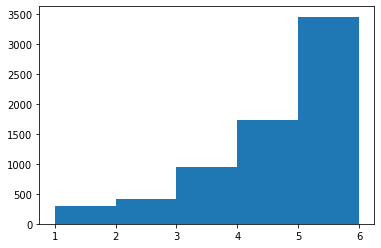

In [209]:
plt.hist(ratings, bins = [1,2,3,4,5,6])
#plt.hist(ratings)

4.113510358914502
1.2643257865136441


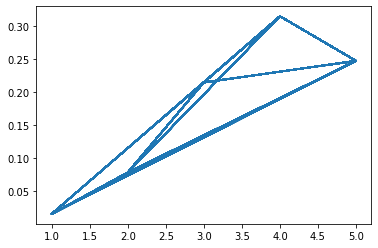

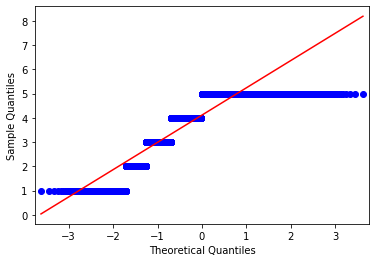

In [210]:
r=np.array(ratings)
mean=np.mean(r)
var=np.var(r)
print(mean)
print(var)
plt.plot(r, stats.norm.pdf(r, mean, var))
plt.show()
qqplot(r, line='s')
plt.show()

In [211]:
#Baseline

base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=baseline)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4dae8cd52da8500c9e3b044aad89f788 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_4dae8cd52da8500c9e3b044aad89f788.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      3.84    0.22   0.43   3.04   3.55   3.77   4.16   4.73      4   1.64
truescore[2]      4.09    0.22   0.46    3.3   3.65   4.12   4.45   4.83      4   1.85
truescore[3]      3.91    0.07   0.37   3.15   3.66   3.95   4.19   4.55     31   1.16
truescore[4]      4.16    0.12   0.48   3.09   3.92   4.15   4.43   5.19     16   1.21
truescore[5]      3.81    0.22    0.5   2.81   3.45    3.8   4.28   4.56      5   1.47
truescore[6]      4.01    0.23   0.41   2.99   3.79   4.08   4.28   4.65      3   1.84
truescore[7]       3.7    0.11   0.49   2.79   3.38   3.72    4.0   4.75     20   1.23
truescore[8]      3.44     0.1   0.32   2.72   3.24   3.46   3.68   3.96     11   1.62
truescore[9]      4.05    0.08

In [212]:
la = fit.extract(permuted=False)
print(np.shape(la))

(500, 4, 1324)


In [213]:
#Average goodness and bias
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

3.4921668920009252
0.4202209789960227


In [214]:
#Training RMSE for Baseline
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Baseline",s)

Training RMSE for Baseline 0.7962793373348793


In [215]:
#Testing RMSE for Baseline
s=0
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Baseline",s)

Testing RMSE for Baseline 0.9937865294851455


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


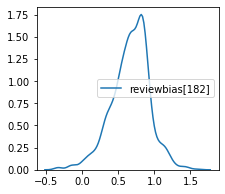

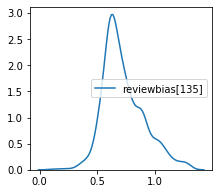

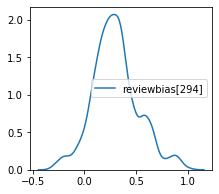

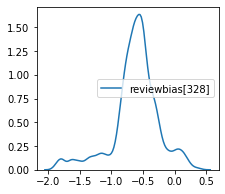

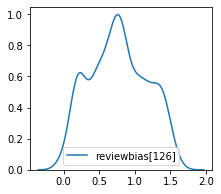

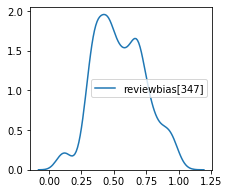

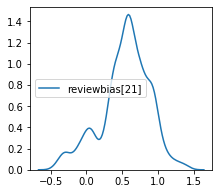

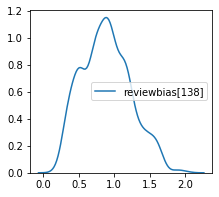

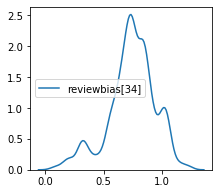

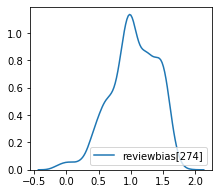

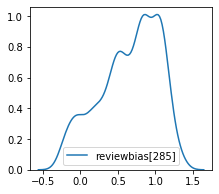

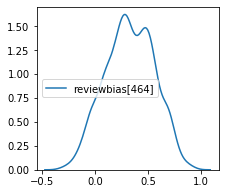

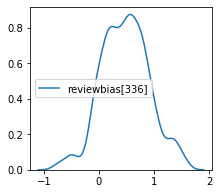

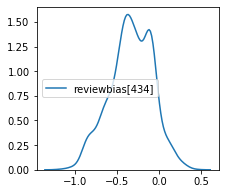

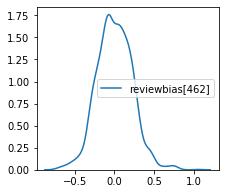

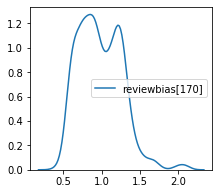

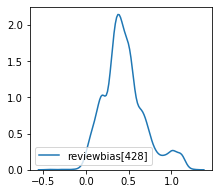

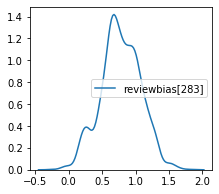

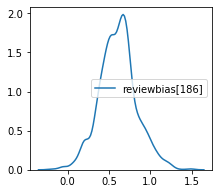

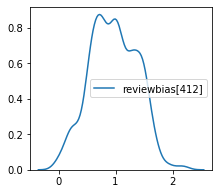

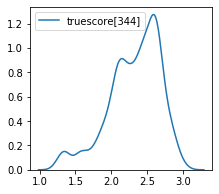

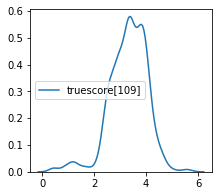

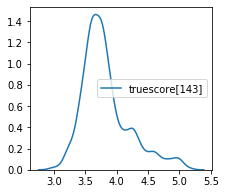

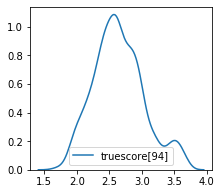

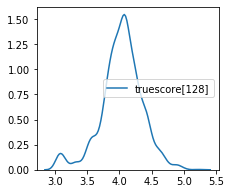

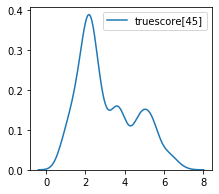

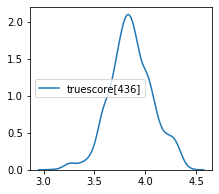

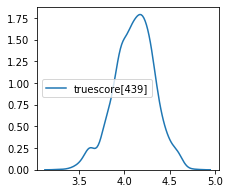

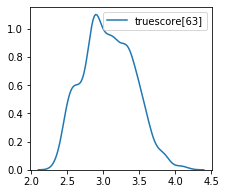

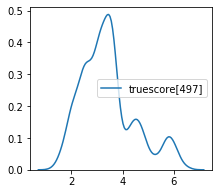

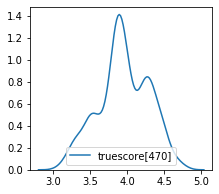

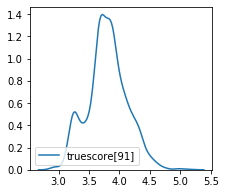

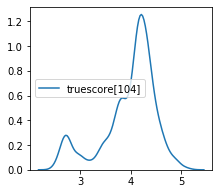

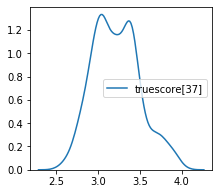

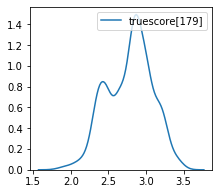

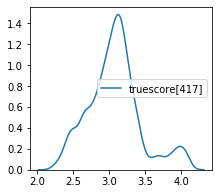

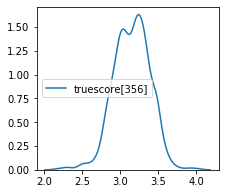

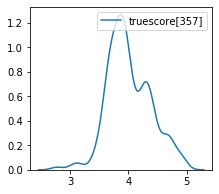

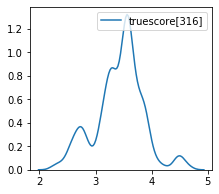

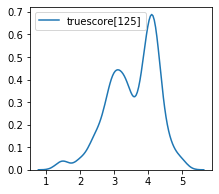

In [216]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [217]:
#Model 1
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model1)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43b4b4d7b8c6d300dbe8725b4fa103b0 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_43b4b4d7b8c6d300dbe8725b4fa103b0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      4.03  9.5e-3   0.42   3.21   3.75   4.03   4.31   4.86   1937    1.0
truescore[2]      4.13  7.2e-3   0.33   3.48    3.9   4.13   4.36   4.76   2110    1.0
truescore[3]      3.81    0.01   0.48   2.87    3.5   3.82   4.13   4.71   2183    1.0
truescore[4]       4.3    0.01   0.47   3.37   3.97   4.31   4.63   5.18   1734    1.0
truescore[5]      3.81  8.6e-3   0.38   3.07   3.55    3.8   4.06   4.57   1951    1.0
truescore[6]      3.82  9.8e-3   0.42   2.99   3.54   3.83   4.11   4.63   1833    1.0
truescore[7]      3.49    0.01   0.56    2.4   3.12   3.49   3.87   4.57   2004    1.0
truescore[8]      3.47  9.2e-3   0.48   2.53   3.14   3.47    3.8   4.43   2720    1.0
truescore[9]      3.85    0.01

In [218]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
3.4937395058650615
0.44882380265972627


In [219]:
#Training RMSE for Model 1
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 1",s)
s=0

#Testing RMSE for Model 1
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 1",s)

Training RMSE for Model 1 0.7781584070519395
Testing RMSE for Model 1 0.9828510774839881


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


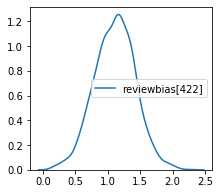

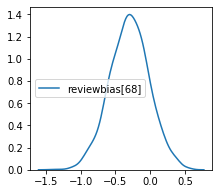

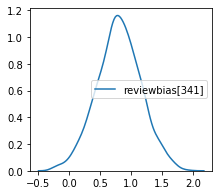

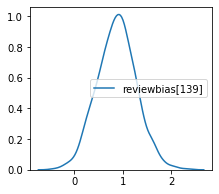

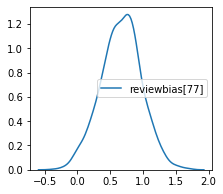

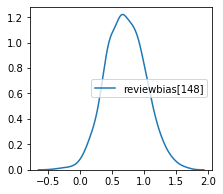

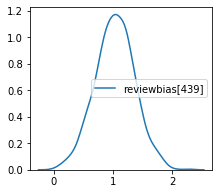

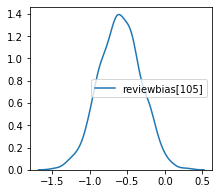

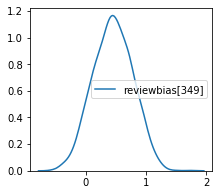

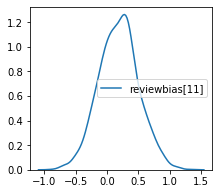

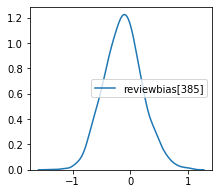

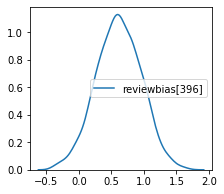

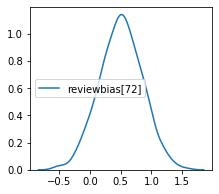

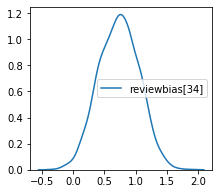

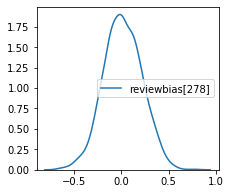

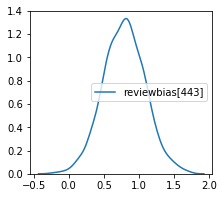

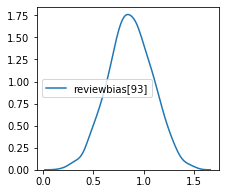

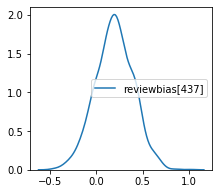

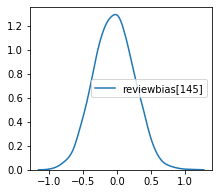

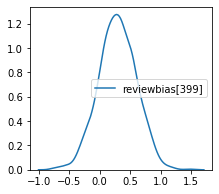

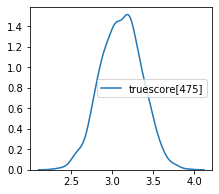

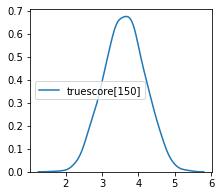

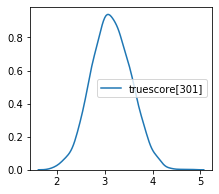

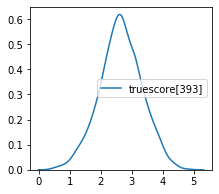

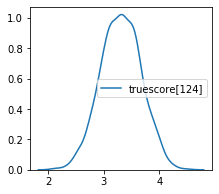

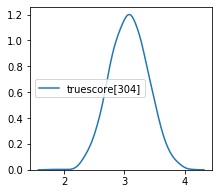

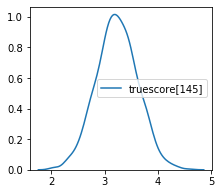

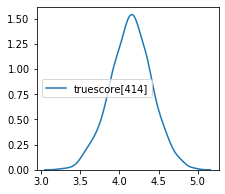

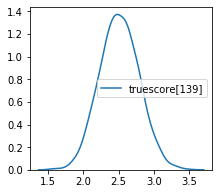

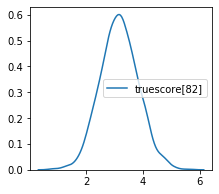

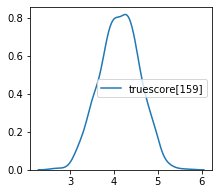

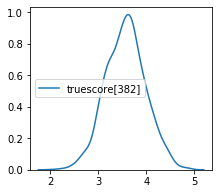

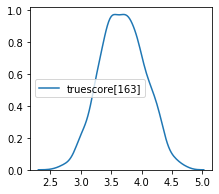

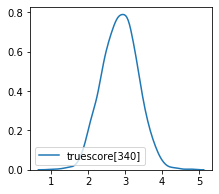

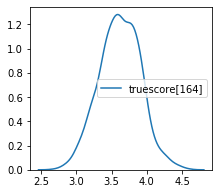

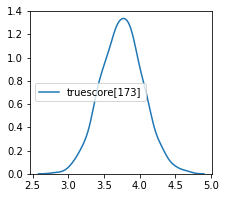

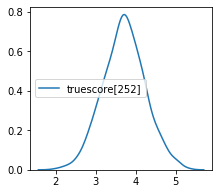

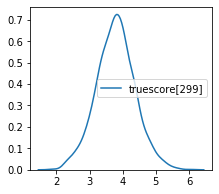

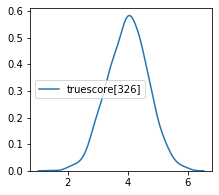

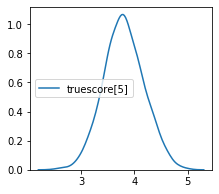

In [220]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [221]:
#Model 2
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'helpfulness':training_data[3], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model2)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c3a422b48e22b2cb2bf4b3b7f3c2095 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_4c3a422b48e22b2cb2bf4b3b7f3c2095.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      4.02  9.5e-3   0.45   3.11   3.74   4.02   4.33    4.9   2254    1.0
truescore[2]      4.18  7.1e-3   0.31   3.56   3.98   4.17   4.39   4.75   1837    1.0
truescore[3]      3.79    0.01    0.5   2.81   3.44    3.8   4.13   4.79   1952    1.0
truescore[4]      4.23    0.01   0.52   3.24   3.88   4.22   4.58   5.27   2297    1.0
truescore[5]      3.81  8.8e-3    0.4   3.06   3.52    3.8   4.08   4.58   2091    1.0
truescore[6]      3.77  9.7e-3   0.42   2.97   3.48   3.76   4.04   4.57   1863    1.0
truescore[7]      3.44    0.01   0.55   2.38   3.06   3.45   3.81   4.51   2679    1.0
truescore[8]      3.32  9.7e-3   0.46   2.44   3.01   3.33   3.65   4.22   2219    1.0
truescore[9]      3.89    0.01

In [222]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
3.4887788093354226
0.4426745287812734


In [223]:
#Training RMSE for Model 1
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 1",s)
s=0

#Testing RMSE for Model 1
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 1",s)

Training RMSE for Model 1 0.7814089208129826
Testing RMSE for Model 1 0.9855925437294047


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


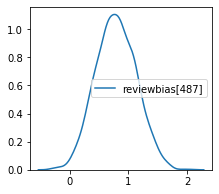

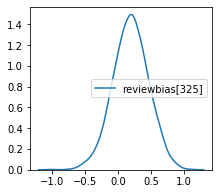

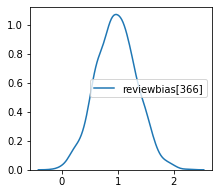

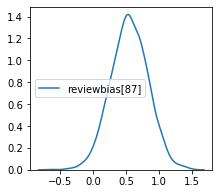

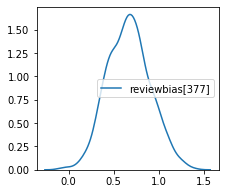

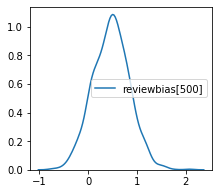

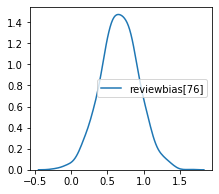

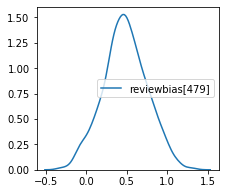

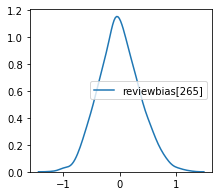

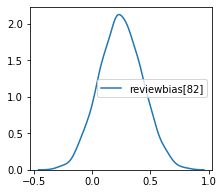

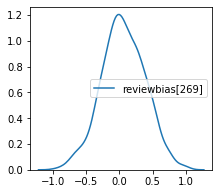

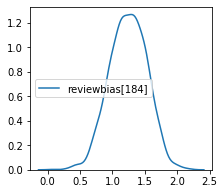

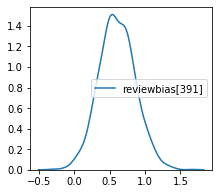

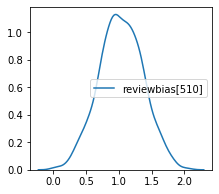

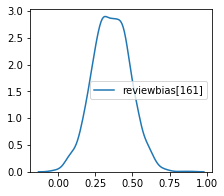

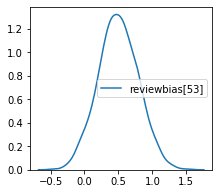

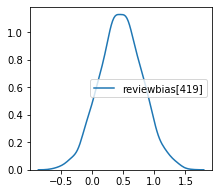

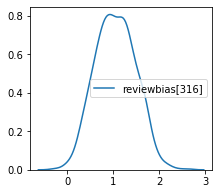

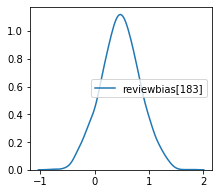

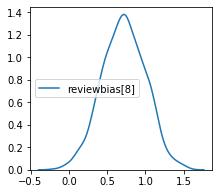

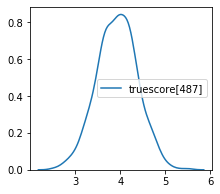

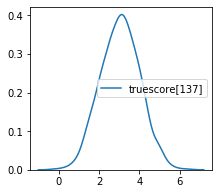

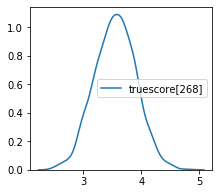

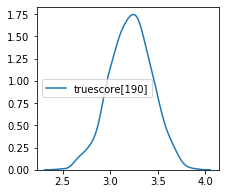

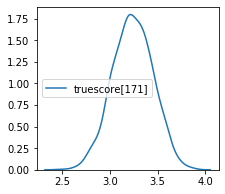

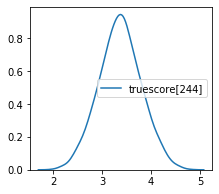

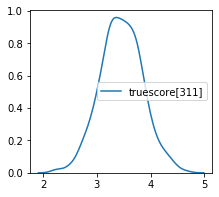

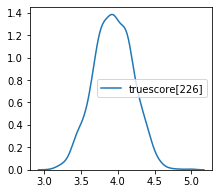

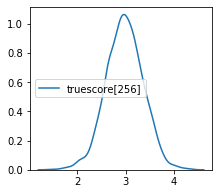

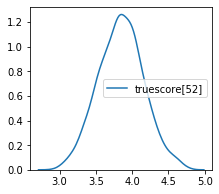

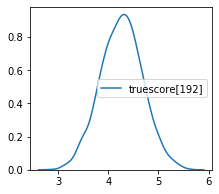

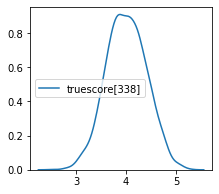

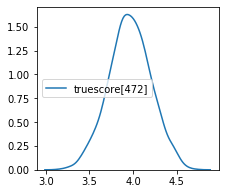

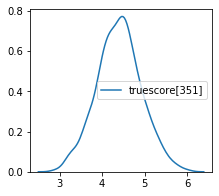

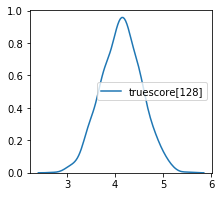

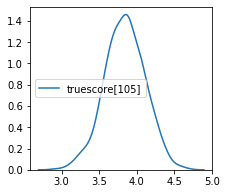

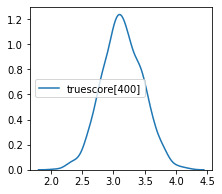

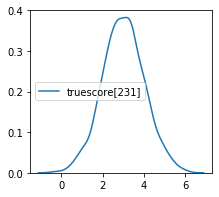

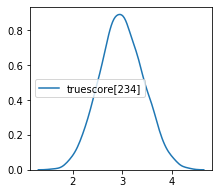

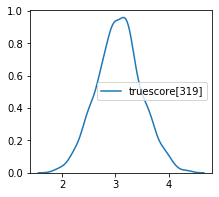

In [224]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [225]:
#Model 3
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'helpfulness':training_data[3], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a58fdecda7b34ec2cd922c960edf3761 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_a58fdecda7b34ec2cd922c960edf3761.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      4.79    0.05   0.21   4.23   4.68   4.81   4.94   5.11     21   1.06
truescore[2]      4.59    0.08   0.32   3.86   4.43   4.59   4.79    5.2     16   1.44
truescore[3]      4.49    0.26   0.45   3.63   4.17   4.48   4.93   5.16      3   1.95
truescore[4]      4.69    0.14   0.32    4.1   4.42   4.69   4.89   5.41      5   1.42
truescore[5]      4.35    0.13   0.35   3.63   4.08   4.43   4.61    4.9      7    1.3
truescore[6]      4.83    0.07   0.33   4.08   4.63   4.86   5.04   5.44     21   1.15
truescore[7]      3.96    0.48   0.77   2.96   3.31   3.72   4.52    5.6      3   2.41
truescore[8]      4.04     0.1   0.34   3.29   3.85   4.04   4.28   4.66     12   1.43
truescore[9]      4.23    0.12

In [226]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
4.11105260720637
-0.006928196264647018


In [227]:
#Training RMSE for Model 3
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 1",s)
s=0

#Testing RMSE for Model 3
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 1",s)

Training RMSE for Model 1 0.8030483611319682
Testing RMSE for Model 1 0.9919250892164847


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


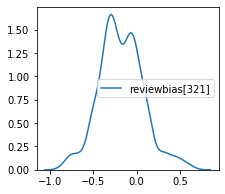

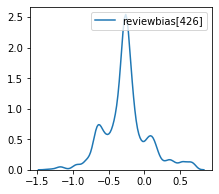

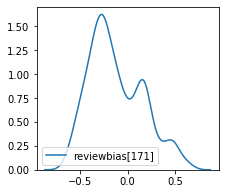

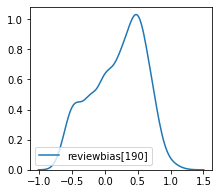

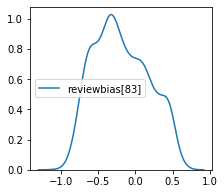

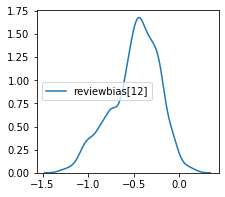

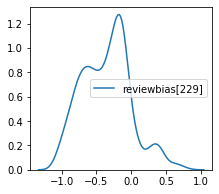

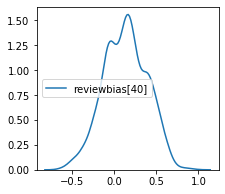

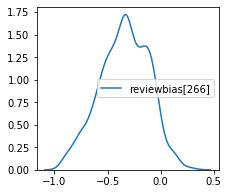

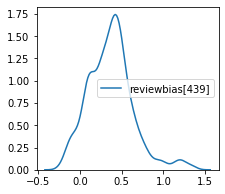

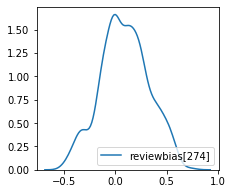

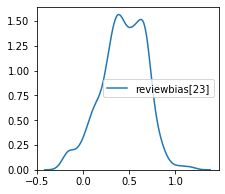

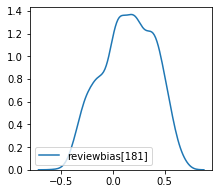

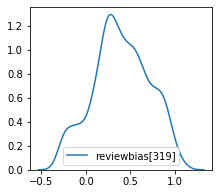

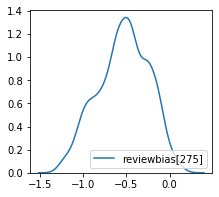

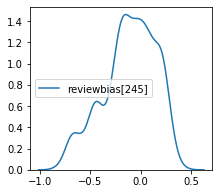

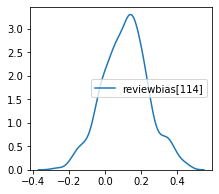

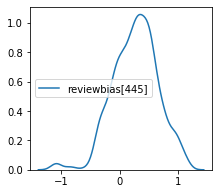

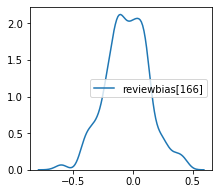

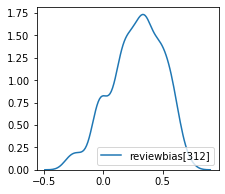

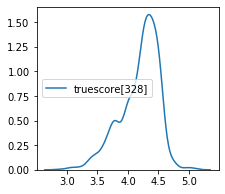

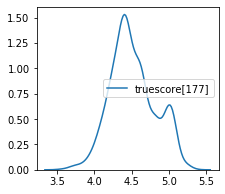

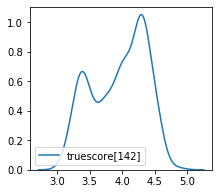

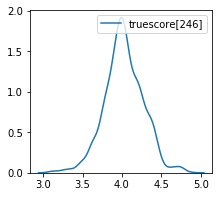

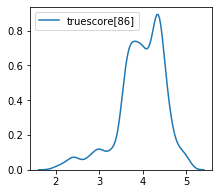

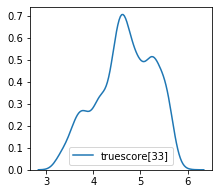

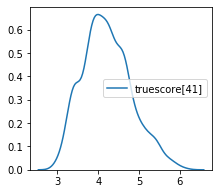

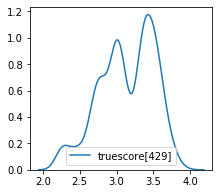

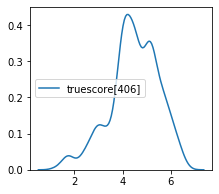

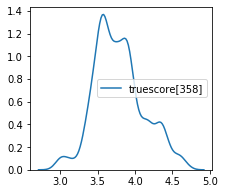

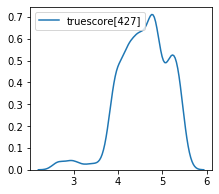

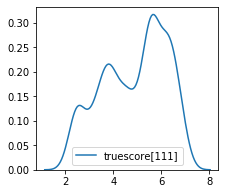

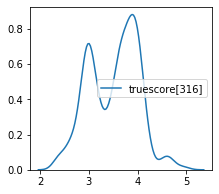

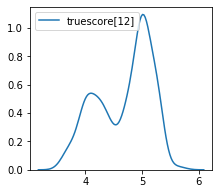

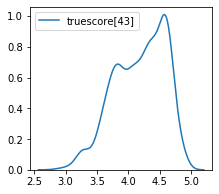

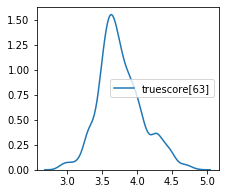

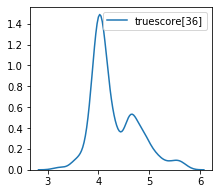

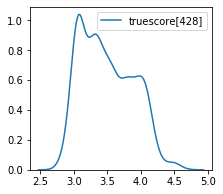

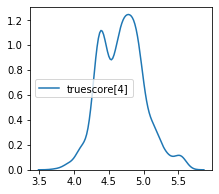

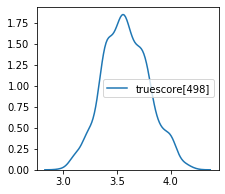

In [228]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [230]:
#Model 4
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'helpfulness':training_data[3], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model4)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8aff17752918bfa9b806a58bfa585319 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_8aff17752918bfa9b806a58bfa585319.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]       4.6  9.3e-3   0.42   3.76   4.31    4.6   4.88   5.41   2010    1.0
truescore[2]      4.63  7.7e-3   0.34   3.95   4.39   4.63   4.86   5.29   1963    1.0
truescore[3]      4.56    0.01   0.49   3.59   4.22   4.58   4.88   5.56   1865    1.0
truescore[4]      5.02    0.01   0.48   4.11   4.69   5.01   5.35   5.95   2071    1.0
truescore[5]      4.42  7.5e-3   0.35   3.75   4.17   4.42   4.66   5.08   2183    1.0
truescore[6]      4.43  8.9e-3   0.43    3.6   4.14   4.43    4.7   5.28   2390    1.0
truescore[7]      4.02    0.01   0.56   2.98   3.64   4.02    4.4   5.09   1775    1.0
truescore[8]      4.12    0.01   0.48   3.15    3.8   4.11   4.44   5.06   2174    1.0
truescore[9]      4.51    0.01

In [231]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
4.101167727790753
0.0003955909388098608


In [233]:
#Training RMSE for Model 3
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 4",s)
s=0

#Testing RMSE for Model 3
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 4",s)

Training RMSE for Model 4 0.7806400239513264
Testing RMSE for Model 4 0.9703979516074375
